In [85]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [86]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [87]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [88]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [89]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [90]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [91]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

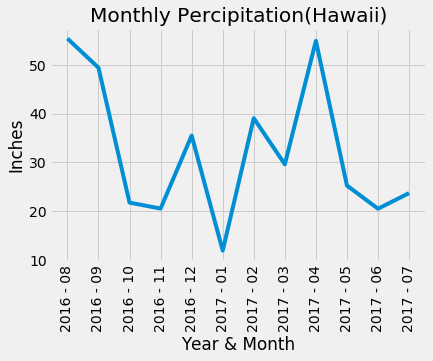

In [92]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# I made the descision to group the data by month and year.  This made the graph easier to read. 

perc = engine.execute("select * from(SELECT strftime('%Y - %m',date) as period, Sum(prcp) AS SumOfprcp " + # Perform a query to retrieve the data and precipitation scores
                      "from Measurement " + 
                      "where date <'2017-08-01'"  # Calculate the date 1 year ago from the last data point in the database
                      "group by strftime('%Y - %m',date) " +
                      "Order by strftime('%Y - %m',date)desc " + # Sort the dataframe by date
                      "Limit 12) "  + #limited the data to the last 12 months
                      "Order by period")

# the data tables had 5 days of data for the month of august 2017 as it was not a complete month I omited that data.

Data = pd.DataFrame(perc) # Save the query results as a Pandas DataFrame and set the index to the date column
Data = Data.rename(columns={0: "Date", 1: "Percipitation"})
Date = Data["Date"]
Perct = Data["Percipitation"]

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(Date, Perct)
plt.xticks(rotation=90)
plt.xlabel("Year & Month")
plt.ylabel("Inches")
plt.title("Monthly Percipitation(Hawaii)")
plt.show()



In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Data.describe()

Percipitation
count      12.000000
mean       32.306667
std        14.537070
min        11.950000
25%        21.467500
50%        27.445000
75%        41.645000
max        55.390000

In [99]:
#Stations Count
Stations = engine.execute("Select count(station) from Station")
               

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stn = pd.DataFrame(Stations)
stn = stn.rename(columns={0: "Station Count"})
stn.head(20)


Station Count
0              9

In [100]:
# Design a query to show how many stations are available in this dataset?

Stations = engine.execute("Select Station.station, name, count(prcp) from Station " +
                          "join Measurement on Station.station = Measurement.station " +
                          "group by name " +
                        "Order by count(prcp)desc")

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Data1 = pd.DataFrame(Stations)
Data1 = Data1.rename(columns={0: "Station id", 1: "Locaiton", 2:"Count of Entries"})
Data1.head(20)

Station id                                Locaiton  Count of Entries
0  USC00519281                     WAIHEE 837.5, HI US              2772
1  USC00513117                    KANEOHE 838.1, HI US              2696
2  USC00519397                    WAIKIKI 717.2, HI US              2685
3  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US              2572
4  USC00516128            MANOA LYON ARBO 785.2, HI US              2484
5  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US              1937
6  USC00511918       HONOLULU OBSERVATORY 702.2, HI US              1932
7  USC00517948                       PEARL CITY, HI US               683
8  USC00518838              UPPER WAHIAWA 874.3, HI US               342

In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Stations1 = engine.execute("Select Station.station, name, min(tobs), max(tobs), avg(tobs), count(tobs) from Station " +
                          "join Measurement on Station.station = Measurement.station " + 
                          " Where Station.station = 'USC00519281' " +
                          "group by name " +
                        "Order by count(prcp)desc")

# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

Data2 = pd.DataFrame(Stations1)
Data2 = Data2.rename(columns={0: "Station id", 1: "Locaiton", 2:"Min-Temp ", 3: "Max-Temp", 4: "Avg-Temp", 5: "Count of Entries"})
Data2.head(20)


Station id             Locaiton  Min-Temp   Max-Temp   Avg-Temp  \
0  USC00519281  WAIHEE 837.5, HI US       54.0      85.0  71.663781   

   Count of Entries  
0              2772

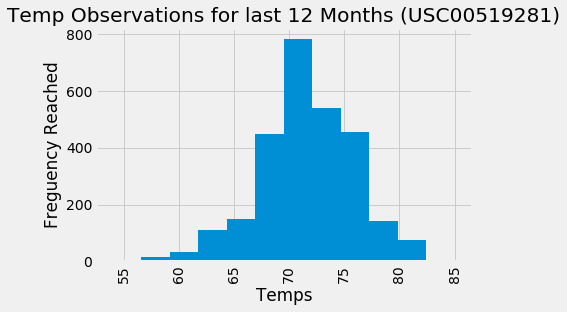

In [126]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Temp = engine.execute("SELECT station, date, tobs " + 
                      "from Measurement " + 
                      "where date <'2017-08-01'and station = 'USC00519281' "  +
                      "group by date") 
                      
                     
Data3 = pd.DataFrame(Temp) # Save the query results as a Pandas DataFrame and set the index to the date column
Data3 = Data3.rename(columns={0: "Station", 1: "Date", 2: "Temps"})
Date = Data3["Date"]
TP = Data3["Temps"]

plt.hist(TP,bins=12)
plt.xticks(rotation=90)
plt.xlabel("Temps")
plt.ylabel("Freguency Reached")
plt.title("Temp Observations for last 12 Months (USC00519281)")
plt.savefig("Resources/TemperaturevsFrequency.png")
plt.show()
#Data3.head()

![precipitation](Images/station-histogram.png)

In [103]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [104]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-10-01', '2016-10-15'))

[(71.0, 77.78947368421052, 82.0)]


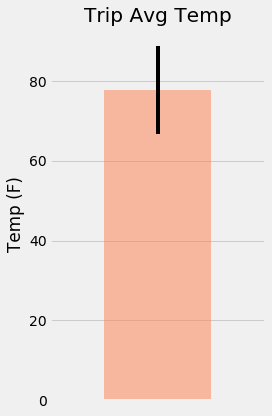

In [142]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip = calc_temps('2016-10-01', '2016-10-15')
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [144]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2016-10-01', '2016-10-15'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.02), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.14), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.14), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.08), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.07), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


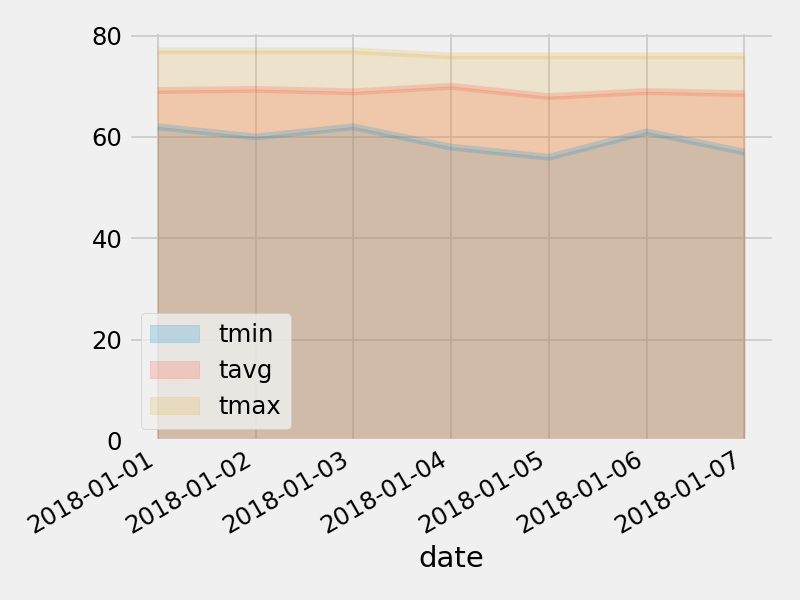

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
